<a href="https://colab.research.google.com/github/amina04/CNN-lstm/blob/main/LSTM_nsl_kdd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout,Embedding

In [3]:
data_train=pd.read_csv('/content/drive/MyDrive/data/nsl-kdd/KDDTrain+.txt' ,delimiter=',', header=None)
data_test=pd.read_csv('/content/drive/MyDrive/data/nsl-kdd/KDDTest+.txt' ,delimiter=',', header=None)
data_test1=pd.read_csv('/content/drive/MyDrive/data/nsl-kdd/KDDTest-21.txt' ,delimiter=',', header=None)

In [4]:
import pandas as pd
new_data_train= pd.concat([data_train, data_test1]).drop_duplicates(keep=False)
new_data_train.reset_index(drop=True, inplace = True)
    

In [5]:
print(new_data_train.shape)
print(data_test.shape)

(136873, 43)
(22544, 43)


In [6]:
new_data_train.isnull().values.any()


False

In [7]:
#les noms des colonne de dataset
featuresV=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]
#la colonne flag qui contient des valeur string
flagV=['OTH','RSTOS0','SF','SH','RSTO','S2','S1','REJ','S3','RSTR','S0']

#la colonne protocol_type qui contient des valeur string
protocol_typeV=['tcp','udp','icmp']
#la colonne service qui contient des valeur string
serviceV=['http','smtp','finger','domain_u','auth','telnet','ftp','eco_i','ntp_u','ecr_i','other','private','pop_3','ftp_data',
                  'rje','time','mtp','link','remote_job','gopher','ssh','name','whois','domain','login','imap4','daytime','ctf','nntp',
                  'shell','IRC','nnsp','http_443','exec','printer','efs','courier','uucp','klogin','kshell','echo','discard','systat',
                  'supdup','iso_tsap','hostnames','csnet_ns','pop_2','sunrpc','uucp_path','netbios_ns','netbios_ssn','netbios_dgm',
                  'sql_net','vmnet','bgp','Z39_50','ldap','netstat','urh_i','X11','urp_i','pm_dump','tftp_u','tim_i','red_i','icmp',
                  'http_2784','harvest','aol','http_8001']
# les étiquète 
binary_attack=['normal','ipsweep', 'nmap', 'portsweep','satan', 'saint', 'mscan','back', 'land', 'neptune', 'pod', 'smurf',
               'teardrop', 'apache2', 'udpstorm', 'processtable','mailbomb','buffer_overflow', 'loadmodule', 'perl', 'rootkit',
               'xterm', 'ps', 'sqlattack','ftp_write', 'guess_passwd', 'imap', 'multihop','phf', 'spy', 'warezclient',
               'warezmaster','snmpgetattack','named', 'xlock', 'xsnoop','sendmail', 'httptunnel', 'worm', 'snmpguess']

multiclass_attack={ 'normal': 'normal',
        'probe': ['ipsweep.', 'nmap.', 'portsweep.','satan.', 'saint.', 'mscan.'],
        'dos': ['back.', 'land.', 'neptune.', 'pod.', 'smurf.','teardrop.', 'apache2.', 'udpstorm.', 'processtable.','mailbomb.'],
        'u2r': ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.','xterm.', 'ps.', 'sqlattack.'],
        'r2l': ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.','phf.', 'spy.', 'warezclient.', 'warezmaster.','snmpgetattack.',
                   'named.', 'xlock.', 'xsnoop.','sendmail.', 'httptunnel.', 'worm.', 'snmpguess.']}  

In [8]:
new_data_train.columns=data_test.columns=featuresV

In [9]:
df_train_obj = new_data_train.iloc[:, :-2].select_dtypes(include='object')
df_train_num = new_data_train.iloc[:, :-2].select_dtypes(exclude='object')

print(f"shape of numeric features: {df_train_num.shape}")
print(f"shape of object features: {df_train_obj.shape}")

shape of numeric features: (136873, 38)
shape of object features: (136873, 3)


In [10]:
df_test_obj = data_test.iloc[:, :-2].select_dtypes(include='object')
df_test_num = data_test.iloc[:, :-2].select_dtypes(exclude='object')

print(f"shape of numeric features: {df_test_num.shape}")
print(f"shape of object features: {df_test_obj.shape}")

shape of numeric features: (22544, 38)
shape of object features: (22544, 3)


In [11]:
new_data_train['label']=new_data_train['label'].replace(['normal.','normal'],0)
for i in range(len(binary_attack)):
  new_data_train['label'] = new_data_train['label'].replace(binary_attack[i], 1)
y_train=new_data_train['label']
data_test['label']=data_test['label'].replace(['normal.','normal'],0)
for i in range(len(binary_attack)):
  data_test['label'] = data_test['label'].replace(binary_attack[i], 1)
y_test=data_test['label']
#supprimer la colonne la bel de dataset car on a créer une copier déja ===>séparation
del new_data_train['label']
del data_test['label']

In [12]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

#encoder juste les  column qui contient string
data_train_enc = enc.fit_transform(df_train_obj).toarray()
train_enc_features = enc.get_feature_names_out(input_features=df_train_obj.columns)
data_test_enc = enc.transform(df_test_obj).toarray()
test_enc_features = enc.get_feature_names_out(input_features=df_test_obj.columns)

#concatiner string avec num columns
X_train_enc = np.c_[df_train_num, data_train_enc]
X_test_enc = np.c_[df_test_num, data_test_enc]
print(f"X_train_enc shape: {X_train_enc.shape}")
print(f"X_test_enc shape: {X_test_enc.shape}")
######################################
#encoder les labels
y_train=pd.get_dummies(y_train)
y_test=pd.get_dummies(y_test)
y_train.head()


X_train_enc shape: (136873, 122)
X_test_enc shape: (22544, 122)


,0,1
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0


In [13]:
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train_enc)
X_test_scaler = scaler.fit_transform(X_test_enc)
########################
y_train=scaler.fit_transform(y_train)
y_test=scaler.fit_transform(y_test)
y_train[0]

array([1., 0.])

In [14]:
x_train = np.reshape(X_train_scaler, (X_train_scaler.shape[0], X_train_scaler.shape[1],1))
x_train.shape

(136873, 122, 1)

In [15]:
from sklearn.model_selection import train_test_split
# The next step is to split training and testing data. For this we will use sklearn function train_test_split().

x_train, x_test1 ,y_train, y_test1 = train_test_split(x_train, y_train, test_size=10000)
x_train.shape, x_test1.shape ,y_train.shape, y_test1.shape

((126873, 122, 1), (10000, 122, 1), (126873, 2), (10000, 2))

In [16]:
x_test = np.reshape(X_test_scaler, (X_test_scaler.shape[0],X_test_scaler.shape[1],1))

x_test.shape

(22544, 122, 1)

In [17]:
y_test.shape

(22544, 2)

In [18]:
from tensorflow import keras
from tensorflow.keras.layers import Flatten
model = Sequential()
#model.add(Input(shape=(None,(x_train.shape[1]))))
model.add(LSTM(40,activation='relu',input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(30,activation='relu',return_sequences=True))
model.add(Dropout(0.2)) 
model.add(LSTM(20,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=15, activation='relu'))
model.add(Dense(2,activation="sigmoid"))
    

model.summary()
   


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 122, 40)           6720      
                                                                 
 dropout (Dropout)           (None, 122, 40)           0         
                                                                 
 lstm_1 (LSTM)               (None, 122, 30)           8520      
                                                                 
 dropout_1 (Dropout)         (None, 122, 30)           0         
                                                                 
 lstm_2 (LSTM)               (None, 122, 20)           4080      
                                                                 
 dropout_2 (Dropout)         (None, 122, 20)           0         
                                                                 
 flatten (Flatten)           (None, 2440)              0

In [19]:
model.compile(loss="binary_crossentropy", optimizer='Adam' , metrics=['accuracy',keras.metrics.Precision()])

In [20]:

#X_train_lstm = X_train_extract.reshape(X_train_extract.shape[0], 1, X_train_extract.shape[1])
#X_test_lstm = X_test_extract.reshape(X_test_extract.shape[0], 1, X_test_extract.shape[1])
history=model.fit(x_train, y_train, epochs=80, batch_size=256, validation_data=(x_test,y_test))

Epoch 1/80
496/496 [==============================] - 226s 430ms/step - loss: 0.2980 - accuracy: 0.8787 - precision: 0.8802 - val_loss: 0.4425 - val_accuracy: 0.7681 - val_precision: 0.7691
Epoch 2/80
496/496 [==============================] - 212s 428ms/step - loss: 77226.3047 - accuracy: 0.8812 - precision: 0.8818 - val_loss: 0.4937 - val_accuracy: 0.7485 - val_precision: 0.7485
Epoch 3/80
496/496 [==============================] - 211s 425ms/step - loss: 0.2210 - accuracy: 0.9147 - precision: 0.9139 - val_loss: 0.3753 - val_accuracy: 0.8215 - val_precision: 0.8182
Epoch 4/80
496/496 [==============================] - 217s 437ms/step - loss: 0.1844 - accuracy: 0.9307 - precision: 0.9306 - val_loss: 0.3415 - val_accuracy: 0.8229 - val_precision: 0.8218
Epoch 5/80
 27/496 [>.............................] - ETA: 3:07 - loss: 0.1737 - accuracy: 0.9337 - precision: 0.9339

KeyboardInterrupt: ignored

In [21]:
#check accuaracy of prediction
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score, recall_score
#model.score(x_valid,y_valid)

In [22]:
#cf_matrix=confusion_matrix(y_valid, y_pred)
y_test_arg=np.argmax(y_test1,axis=1)
Y_pred = np.argmax(model.predict(x_test1),axis=1)
print('Confusion Matrix')
cf_matrix=confusion_matrix(y_test_arg, Y_pred)
print(cf_matrix)

Confusion Matrix
[[4878  152]
 [ 482 4488]]


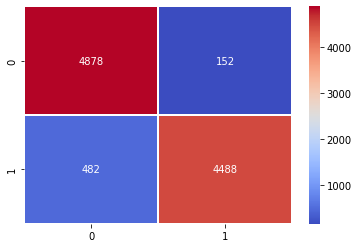

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cf_matrix, cmap='coolwarm',annot=True, linewidth=1,fmt="d")
plt.show()

In [24]:
accuracy =accuracy_score(y_test_arg, Y_pred)*100
print(accuracy)

93.66


In [25]:
recall = recall_score(y_test_arg, Y_pred , average="binary")
precision = precision_score(y_test_arg, Y_pred, average="binary")
FPR = cf_matrix[0][1]/(cf_matrix[0][1]+cf_matrix[1][1]) 

In [26]:
print("Precision : " , precision*100)
print("Recall : ", recall*100)
print("Accuracy : ",accuracy)
print("FPR : ",FPR*100)

Precision :  96.72413793103448
Recall :  90.30181086519114
Accuracy :  93.66
FPR :  3.2758620689655173
